In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix,classification_report
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
splits = {'train': 'train.csv', 'test': 'test.csv'}
df_train = pd.read_csv("hf://datasets/osyvokon/pavlick-formality-scores/" + splits["train"])
df_test = pd.read_csv("hf://datasets/osyvokon/pavlick-formality-scores/" + splits["test"])


In [3]:
df_train.head()

,domain,avg_score,sentence
0,news,-0.6,Tang was employed at private-equity firm Fried...
1,news,1.0,San Francisco Mayor Gavin Newsom's withdrawal ...
2,answers,-2.8,lol nothing worrying about that.
3,news,0.0,She told Price she wanted to join the Police E...
4,news,1.8,The prime minister is keen to use the autumn p...


In [4]:
df_train.avg_score.value_counts()

avg_score
 1.000000    507
 0.000000    495
 0.800000    492
 0.600000    475
 0.400000    473
            ... 
 3.000000      6
-2.666667      6
 2.666667      6
 1.333333      4
 2.333333      1
Name: count, Length: 61, dtype: int64

In [5]:
df_train.drop(df_train[df_train['avg_score']==0.0].index, inplace=True)
df_test.drop(df_test[df_test['avg_score']==0.0].index, inplace=True)

In [6]:
def cleaning_label(value):
    if value>0:
        return 2
    if value < 0:
        return 1

df_train['label'] = df_train.avg_score.apply(cleaning_label)
df_test['label'] = df_test.avg_score.apply(cleaning_label)

In [7]:
df_train.drop(columns=['avg_score'], inplace=True)
df_test.drop(columns=['avg_score'], inplace=True)

In [8]:
df_train.head()

,domain,sentence,label
0,news,Tang was employed at private-equity firm Fried...,1
1,news,San Francisco Mayor Gavin Newsom's withdrawal ...,2
2,answers,lol nothing worrying about that.,1
4,news,The prime minister is keen to use the autumn p...,2
5,blog,Those competencies include mastering fundament...,2


In [9]:
df_train.label.value_counts()

label
2    4600
1    4179
Name: count, dtype: int64

In [10]:
df_test.label.value_counts()

label
2    1017
1     876
Name: count, dtype: int64

In [11]:
from sklearn.utils import resample

majority_class = df_train['label'].value_counts().idxmax()
minority_class = df_train['label'].value_counts().idxmin()

dfs = [df_train[df_train['label'] == i] for i in df_train['label'].unique()]

target_size = min(df_train['label'].value_counts())
balanced_dfs = [resample(d, replace=False, n_samples=target_size, random_state=42) if len(d) > target_size else d for d in dfs]

# Option 2: Oversample minority classes
# target_size = max(df['label'].value_counts())  # Set target size as the size of the largest class
# balanced_dfs = [resample(d, replace=True, n_samples=target_size, random_state=42) if len(d) < target_size else d for d in dfs]

# Combine balanced subsets
balanced_df = pd.concat(balanced_dfs)

# Shuffle the dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Check new class distribution
print(balanced_df['label'].value_counts())


label
2    4179
1    4179
Name: count, dtype: int64


In [12]:
import re

# Simple text cleaning function
def simple_cleaning(text):
    if not isinstance(text, str):  # Handle non-string entries
        return ""
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    return text

# Apply the function
balanced_df['sentence'] = balanced_df['sentence'].apply(simple_cleaning)

print("Text processing complete!")


Text processing complete!


In [13]:
balanced_df.dropna(inplace=True)
balanced_df.drop_duplicates(subset=['sentence'],inplace=True)
balanced_df.shape

(8328, 3)

In [ ]:
balanced_df.isnull().sum()

domain      0
sentence    0
label       0
dtype: int64

In [15]:
balanced_df.drop(columns=['domain'],inplace = True)

In [16]:
balanced_df.head()

,sentence,label
0,he had even spent time online researching thei...,2
1,i like most of the bands you like,1
2,then get up to the top of the theater roof wit...,2
3,for all of this bulkeley was promoted to lieut...,2
4,a few weeks earlier one of lozanos family memb...,2


In [17]:
balanced_df.label.value_counts()

label
2    4171
1    4157
Name: count, dtype: int64

In [18]:
balanced_df.to_csv("cleaned_dataset.csv", index=False)

In [19]:
df1 = pd.read_csv("cleaned_dataset.csv")
df1.shape

(8328, 2)

In [20]:
df1.isnull().sum()

sentence    1
label       0
dtype: int64

In [21]:
df1.dropna(inplace=True)

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler

# Separate features and target
X = df1['sentence']  # Feature column
y = df1['label']  # Target column

# Vectorize the text data using TF-IDF
vectorizer = CountVectorizer(max_features=10000)  # Adjust max_features as needed
X_train_vectorized = vectorizer.fit_transform(X).toarray()
X_test_vectorized = vectorizer.transform(df_test['sentence']).toarray()
# Save the processed datasets into a single .npz file
np.savez('processed_dataset.npz',
         X_train=X_train_vectorized,
         X_test=X_test_vectorized,
         y_train=y,
         y_test=df_test['label'])

print("Processed data saved successfully as 'processed_dataset.npz'.")


Processed data saved successfully as 'processed_dataset.npz'.


In [23]:
# Load the .npz file
data = np.load('processed_dataset.npz')

# Access the individual arrays
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

# Print the shapes of the original dataset
print("Original Data Shapes:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

# Reduce the dataset size by selecting a subset (e.g., 10%)
# subset_size = int(0.5 * X_train.shape[0])  # 10% of the dataset
# X_train_subsampled = X_train[:subset_size]
# y_train_subsampled = y_train[:subset_size]

# # Print the shapes of the reduced dataset
# print("\nReduced Data Shapes:")
# print("X_train_subsampled:", X_train_subsampled.shape)
# print("y_train_subsampled:", y_train_subsampled.shape)

# Now you can use the reduced dataset for training



Original Data Shapes:
X_train: (8327, 10000)
X_test: (1893, 10000)
y_train: (8327,)
y_test: (1893,)


In [24]:
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

Accuracy: 0.751716851558373


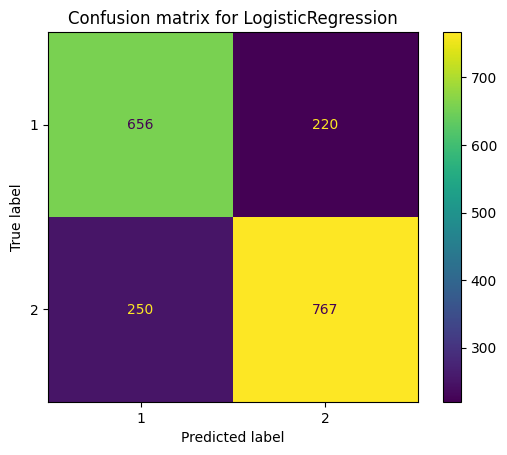

In [25]:
from sklearn.naive_bayes import MultinomialNB

# Initialize and train Multinomial Naive Bayes
model = MultinomialNB()
model.fit(X_train_vectorized, y_train)

# Make predictions
y_pred = model.predict(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion matrix for LogisticRegression")
plt.show()

In [26]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.72      0.75      0.74       876
           2       0.78      0.75      0.77      1017

    accuracy                           0.75      1893
   macro avg       0.75      0.75      0.75      1893
weighted avg       0.75      0.75      0.75      1893



HYPER TUNING RF MODEL

In [27]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Define the hyperparameter space for alpha
param_dist = {
    'alpha': np.logspace(-3, 3, 7)  # Exploring values from 0.001 to 1000
}

# Initialize Multinomial Naive Bayes
model = MultinomialNB()

# Set up RandomizedSearchCV with 5-fold cross-validation
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42)

# Fit the randomized search to the data
random_search.fit(X_train_vectorized, y_train)

# Best parameters found by RandomizedSearchCV
print("Best Parameters:", random_search.best_params_)

# Best model with the optimal hyperparameters
best_model = random_search.best_estimator_

# Make predictions with the best model
y_pred = best_model.predict(X_test_vectorized)

# Evaluate the best model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))


Best Parameters: {'alpha': np.float64(1.0)}
Accuracy: 0.751716851558373
Classification Report:
               precision    recall  f1-score   support

           1       0.72      0.75      0.74       876
           2       0.78      0.75      0.77      1017

    accuracy                           0.75      1893
   macro avg       0.75      0.75      0.75      1893
weighted avg       0.75      0.75      0.75      1893



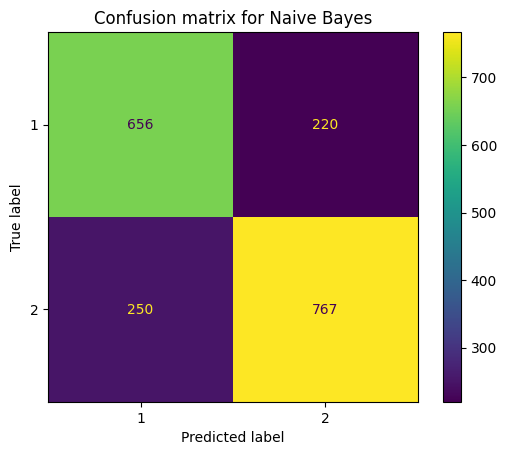

In [28]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion matrix for Naive Bayes")
plt.show()

In [29]:
import joblib

joblib.dump(best_model, "formality.pkl")

['formality.pkl']

In [30]:
#informal : 1 formal : 2
def predict_input_text(input_text):
    # Transform the input text using the same vectorizer that was used during training
    input_vector = vectorizer.transform([input_text])

    # Use the trained model to predict the class label
    prediction = model.predict(input_vector)

    return prediction[0]  # Return the predicted label

# Example usage
input_text ="I look forward to your response at your earliest convenience."
predicted_class = predict_input_text(input_text)

print(f"Predicted Class: {predicted_class}")

NotFittedError: This MultinomialNB instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.